In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap03/'
OutputDir    = '3OLS-0603Polynomial/'
FileBaseName = '3OLS-0603Polynomial'

* Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/


* 必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
import numpy.random as rd
print('numpy      Ver.', np.__version__)
#
############################################
import sklearn as skl
import sklearn.linear_model as lm
import sklearn.preprocessing as prep
print('sklearn    Ver.', skl.__version__)
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
sklearn    Ver. 1.5.2
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3OLS-0603Polynomial/
  making d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap03/3OLS-0603Polynomial/


最小二乗法を線形モデルで行う。
* 多項式回帰を線形モデル
$$
y_{m}
=
a_{0}
+
\sum_{n=1}^{N}
a_n
x_m^n
$$

* $\boldsymbol{\omega}=(a_1, \cdots, a_n, \cdots, a_N)$

* 計画行列 $\boldsymbol{X}$

$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
$$

* 線形写像
$$
\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_{0},
$$
$$
\left(
  \begin{array}{c}
  y_1\\
  \vdots \\
  y_m \\
  \vdots \\
  y_M
  \end{array}
\right)
=
\left(
  \begin{array}{c}
  a_0\\
  \vdots \\
  a_0 \\
  \vdots \\
  a_0
  \end{array}
\right)
+
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
\left(
  \begin{array}{c}
  a_1\\
  \vdots \\
  a_n \\
  \vdots \\
  a_N
  \end{array}
\right)
$$

真値を準備する
* $K=11$とする。
* $a_0=0.2,\,a_1=1.0,\,a_2=0.2,\,a_3=-0.3$ として、それ以外は0とする。
$$
y=0.2+1.0x+0.2x^2-0.3x^3
$$

In [4]:
############################################
# y=0.2+1.0X+0.2X^{2}-0.3X^{3}
#
a_0 = 0.2
#
w_K = 11 - 1
#
w_true = np.zeros((w_K,))
# a_1
w_true[0] = 1.0
# a_2
w_true[1] = 0.2
# a_3
w_true[2] = -0.3
#
print(w_true)

[ 1.   0.2 -0.3  0.   0.   0.   0.   0.   0.   0. ]


解析データの準備
* データ点数: $M=51$
* $x$値の範囲: $x=[-2.0, +2.0]$

In [5]:
############################################
M = 51 # 201
#
x = np.linspace(-2.0,+2.0, num=M, endpoint=True)
#
print(x)

[-2.   -1.92 -1.84 -1.76 -1.68 -1.6  -1.52 -1.44 -1.36 -1.28 -1.2  -1.12
 -1.04 -0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16
 -0.08  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8
  0.88  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68  1.76
  1.84  1.92  2.  ]


計画行列$X$の準備
$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
$$

In [6]:
############################################
X = np.zeros((M, w_K))
#
for k in range(w_K):
    X[:,k] = x**(k+1)
#
print(X)

[[-2.00000000e+00  4.00000000e+00 -8.00000000e+00  1.60000000e+01
  -3.20000000e+01  6.40000000e+01 -1.28000000e+02  2.56000000e+02
  -5.12000000e+02  1.02400000e+03]
 [-1.92000000e+00  3.68640000e+00 -7.07788800e+00  1.35895450e+01
  -2.60919263e+01  5.00964985e+01 -9.61852772e+01  1.84675732e+02
  -3.54577406e+02  6.80788619e+02]
 [-1.84000000e+00  3.38560000e+00 -6.22950400e+00  1.14622874e+01
  -2.10906087e+01  3.88067201e+01 -7.14043650e+01  1.31384032e+02
  -2.41746618e+02  4.44813777e+02]
 [-1.76000000e+00  3.09760000e+00 -5.45177600e+00  9.59512576e+00
  -1.68874213e+01  2.97218616e+01 -5.23104763e+01  9.20664384e+01
  -1.62036931e+02  2.85184999e+02]
 [-1.68000000e+00  2.82240000e+00 -4.74163200e+00  7.96594176e+00
  -1.33827822e+01  2.24830740e+01 -3.77715644e+01  6.34562281e+01
  -1.06606463e+02  1.79098858e+02]
 [-1.60000000e+00  2.56000000e+00 -4.09600000e+00  6.55360000e+00
  -1.04857600e+01  1.67772160e+01 -2.68435456e+01  4.29496730e+01
  -6.87194767e+01  1.09951163e+02

真値データの準備。
$$\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$$

In [7]:
############################################
y_true = X @ w_true + a_0
#
print(y_true)

[ 1.4        1.1406464  0.9059712  0.6950528  0.5069696  0.3408
  0.1956224  0.0705152 -0.0354432 -0.1231744 -0.1936    -0.2476416
 -0.2862208 -0.3102592 -0.3206784 -0.3184    -0.3043456 -0.2794368
 -0.2445952 -0.2007424 -0.1488    -0.0896896 -0.0243328  0.0463488
  0.1214336  0.2        0.2811264  0.3638912  0.4473728  0.5306496
  0.6128     0.6929024  0.7700352  0.8432768  0.9117056  0.9744
  1.0304384  1.0788992  1.1188608  1.1494016  1.1696     1.1785344
  1.1752832  1.1589248  1.1285376  1.0832     1.0219904  0.9439872
  0.8482688  0.7339136  0.6      ]


誤差を重畳させたデータの準備。
* $\boldsymbol{y}_0=\boldsymbol{y}_{\rm true}+{\cal N}(0,\sigma_{0});\;(\sigma_{0}=3.0\times10^{-1})$
* $\boldsymbol{y}_1=\boldsymbol{y}_{\rm true}+{\cal N}(0,\sigma_{1});\;(\sigma_{1}=1.0\times10^{-1})$
* $\boldsymbol{y}_2=\boldsymbol{y}_{\rm true}+{\cal N}(0,\sigma_{2});\;(\sigma_{2}=3.0\times10^{-2})$

In [8]:
############################################
noise = rd.randn(M).reshape(M,)
# ノイズの平均値を0、標準偏差を1に規格化
noise = noise - np.mean( noise )
noise = noise / np.std( noise )
y_0 = y_true + 3.0E-1 * noise
#
noise = rd.randn(M).reshape(M,)
# ノイズの平均値を0、標準偏差を1に規格化
noise = noise - np.mean( noise )
noise = noise / np.std( noise )
y_1 = y_true + 1.0E-1 * noise
#
noise = rd.randn(M).reshape(M,)
# ノイズの平均値を0、標準偏差を1に規格化
noise = noise - np.mean( noise )
noise = noise / np.std( noise )
y_2 = y_true + 3.0E-2 * noise

グラフを描く関数

In [9]:
############################################
def Grf_data( x_data, y_sets, memo=None, title=None ):
  #
  plt.rcParams['font.size'] = 16
  #
  fig = plt.figure( figsize=(7,7) )
  fig.subplots_adjust(left=0.18, right=0.97, top=0.85, bottom=0.1)
  #
  ax1 = fig.add_subplot(1,1,1)
  #
  x_left, x_right = ax1.set_xlim( -2.2, 2.2 )
  ax1.set_xlabel( r'$x$' )
  #
  y_bot, y_top = ax1.set_ylim( -2.0, 2.0 )
  ax1.set_ylabel( r'$y$' )
  #
  for y_set in y_sets:
    # [y_data, plottype, label, 'color', size/linewidth, marker/linestyle]
    #   plottype = 0 -> plot
    #   plottype = 1 -> scatter
    if   y_set[1] == 0:
      #
      ax1.plot( x_data, y_set[0], label=y_set[2], color=y_set[3], linewidth=y_set[4], linestyle=y_set[5] )
      #
    elif y_set[1] == 1:
      #
      ax1.scatter( x_data, y_set[0], label=y_set[2], color=y_set[3], s=y_set[4], marker=y_set[5] )
      #
  #
  if title is not None:
    plt.title( title + r': $y_m=a_0 + \sum_{n=1}^{N}a_n x_m^n$' )
  else:
    plt.title( r'$y_m=a_0 + \sum_{n=1}^{N}a_n x_m^n$' )
  #
  plt.legend(loc='lower right')
  #
  if memo is not None:
    plt.text(x_left, y_bot, memo, fontsize=16,
             horizontalalignment='left',
             verticalalignment='bottom')

  #
  plt.show()
  #
  return fig

データのグラフ描画

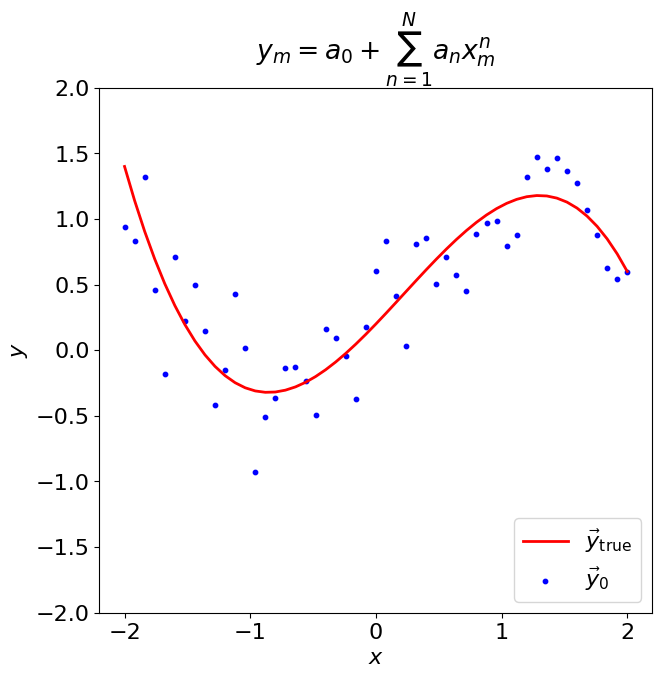

In [10]:
############################################
y_true_set = [ y_true, 0, r'$\vec{y}_{\rm true}$', 'red',  2, 'solid' ]
y_0_set    = [ y_0,    1, r'$\vec{y}_{0}$',       'blue', 10, 'o' ]
#
############################################
y_sets     = [ y_true_set, y_0_set ]
fig = Grf_data( x, y_sets )
#
fig.savefig( FilePath + FileBaseName + '-y0.pdf' )

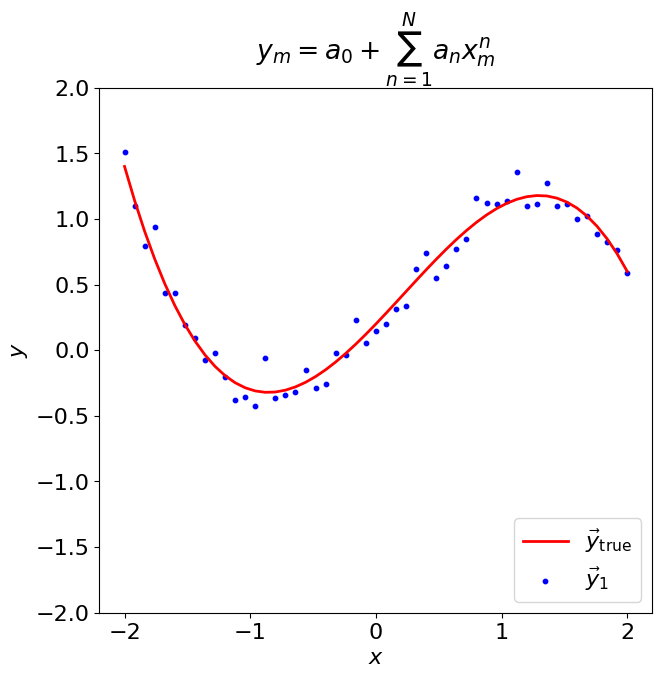

In [11]:
############################################
y_true_set = [ y_true, 0, r'$\vec{y}_{\rm true}$', 'red',  2, 'solid' ]
y_1_set    = [ y_1,    1, r'$\vec{y}_{1}$',       'blue', 10, 'o' ]
#
############################################
y_sets     = [ y_true_set, y_1_set ]
fig = Grf_data( x, y_sets )
#
fig.savefig( FilePath + FileBaseName + '-y1.pdf' )

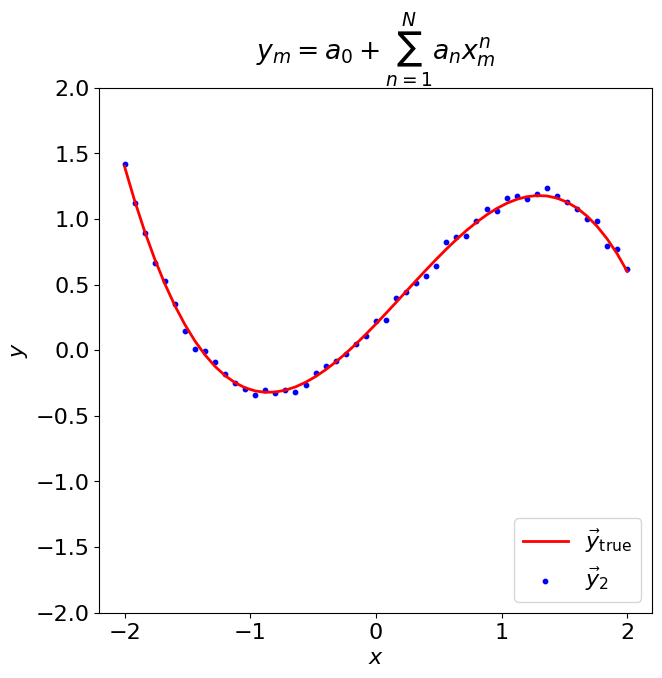

In [12]:
############################################
y_true_set = [ y_true, 0, r'$\vec{y}_{\rm true}$', 'red',  2, 'solid' ]
y_2_set    = [ y_2,    1, r'$\vec{y}_{2}$',       'blue', 10, 'o' ]
#
############################################
y_sets     = [ y_true_set, y_2_set ]
fig = Grf_data( x, y_sets )
#
fig.savefig( FilePath + FileBaseName + '-y2.pdf' )

計画行列$X$を標準化する
* 元行列:
$$
\boldsymbol{X}
=
\left(
  \begin{array}{ccccc}
  x_1 & \cdots & x_1^n & \cdots & x_1^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_m & \cdots & x_m^n & \cdots & x_m^N \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  x_M & \cdots & x_M^n & \cdots & x_M^N
  \end{array}
\right)
$$

* 標準化
```
scalerX = prep.StandardScaler()
scalerX.fit( X )
X_ss = scalerX.transform( X )
```
$$
\tilde{X_{mn}}=\frac{
  X_{mn}-\mu_n
}{
  s_n
}
$$

1. $\mu_n$:  scalerX.mean_[n]
$$
\boldsymbol{\mu}
=
\left(
  \begin{array}{c}
    \mu_{1} \\
    \vdots  \\
    \mu_{n} \\
    \vdots  \\
    \mu_{N}
  \end{array}
\right)
$$

2. $s_n$:    scalerX.scale_[n]

$$
\boldsymbol{s}
=
\left(
  \begin{array}{c}
    s_{1} \\
    \vdots  \\
    s_{n} \\
    \vdots  \\
    s_{N}
  \end{array}
\right)
,
\,\,\,
\boldsymbol{s'}
=
\left(
  \begin{array}{c}
    \frac{1}{s_{1}} \\
    \vdots  \\
    \frac{1}{s_{n}} \\
    \vdots  \\
    \frac{1}{s_{N}}
  \end{array}
\right)
$$


* 標準化された行列:
$$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \tilde{X_{11}} & \cdots & \tilde{X_{1n}} & \cdots & \tilde{X_{1N}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{m1}} & \cdots & \tilde{X_{mn}} & \cdots & \tilde{X_{mN}} \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \tilde{X_{M1}} & \cdots & \tilde{X_{Mn}} & \cdots & \tilde{X_{MN}}
  \end{array}
\right)
$$
1. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の平均値が0
2. $\tilde{X_{1n}},\cdots, \tilde{X_{mn}}, \cdots, \tilde{X_{Mn}}$の標準偏差が1

に標準化される。

$$
\tilde{\boldsymbol{X}}
=
\left(
  \begin{array}{ccccc}
  \frac{X_{11}-\mu_1}{s_1} & \cdots &
  \frac{X_{1n}-\mu_n}{s_n} & \cdots &
  \frac{X_{1N}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{m1}-\mu_1}{s_1} & \cdots &
  \frac{X_{mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{mN}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{M1}-\mu_1}{s_1} & \cdots &
  \frac{X_{Mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{MN}-\mu_N}{s_N}
  \end{array}
\right)
$$


* 標準化していない$\boldsymbol{X}$と切片項$a_0$を用いると、

$$\boldsymbol{y}\approx\boldsymbol{X}\boldsymbol{\omega}+a_0$$

* $\tilde{\boldsymbol{X}}$を使って得られた解を$\hat{\tilde{\boldsymbol{\omega}}}$、切片項を$\hat{a}_0$とする。

$$\boldsymbol{y}\approx\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}+\hat{a}_0$$

$$
\left(
  \begin{array}{c}
    y_{1} - \hat{a}_0 \\
    \vdots            \\
    y_{m} - \hat{a}_0 \\
    \vdots            \\
    y_{M} - \hat{a}_0
  \end{array}
\right)
=
\left(
  \begin{array}{ccccc}
  \frac{X_{11}-\mu_1}{s_1} & \cdots &
  \frac{X_{1n}-\mu_n}{s_n} & \cdots &
  \frac{X_{1N}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{m1}-\mu_1}{s_1} & \cdots &
  \frac{X_{mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{mN}-\mu_N}{s_N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  \frac{X_{M1}-\mu_1}{s_1} & \cdots &
  \frac{X_{Mn}-\mu_n}{s_n} & \cdots &
  \frac{X_{MN}-\mu_N}{s_N}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \hat{\tilde{\omega}}_{1} \\
    \vdots                   \\
    \hat{\tilde{\omega}}_{n} \\
    \vdots                   \\
    \hat{\tilde{\omega}}_{N}
  \end{array}
\right)
$$

$$
=
\left(
  \begin{array}{ccccc}
  X_{11}-\mu_1 & \cdots &
  X_{1n}-\mu_n & \cdots &
  X_{1N}-\mu_N
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1}-\mu_1 & \cdots &
  X_{mn}-\mu_n & \cdots &
  X_{mN}-\mu_N
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1}-\mu_1 & \cdots &
  X_{Mn}-\mu_n & \cdots &
  X_{MN}-\mu_N
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
$$

$$
=
\left(
  \begin{array}{ccccc}
  X_{11} & \cdots &
  X_{1n} & \cdots &
  X_{1N}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{m1} & \cdots &
  X_{mn} & \cdots &
  X_{mN}
  \\
  \vdots & \ddots & \vdots & \ddots & \vdots \\
  X_{M1} & \cdots &
  X_{Mn} & \cdots &
  X_{MN}
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
-
\left(
  \begin{array}{ccccc}
  \mu_1 & \cdots &
  \mu_n & \cdots &
  \mu_N
  \end{array}
\right)
\left(
  \begin{array}{c}
    \frac{\hat{\tilde{\omega}}_{1}}{s_{1}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{n}}{s_{n}} \\
    \vdots                   \\
    \frac{\hat{\tilde{\omega}}_{N}}{s_{N}}
  \end{array}
\right)
$$

よって、

$$
\boldsymbol{y}-\hat{a}_0
\approx
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
=
\boldsymbol{X}\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
-
\boldsymbol{\mu}\,\cdot\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
$$

$$
\therefore\,\,\,
\boldsymbol{y}
\approx
\tilde{\boldsymbol{X}}\hat{\tilde{\boldsymbol{\omega}}}
+\hat{a}_0
=
\boldsymbol{X}\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
-
\boldsymbol{\mu}\,\cdot\,
\left(
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
\right)
+
\hat{a}_0
$$

一方

$$\boldsymbol{y}=\boldsymbol{X}\boldsymbol{\omega}+a_0$$

なので、

$$\boldsymbol{\omega}
  \,
  \leftarrow
  \,
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  $$

$$a_{0}
  \,
  \leftarrow
  \,
  \hat{a}_0
  -
  \boldsymbol{\mu}\,\cdot\,
  \left(
    \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  \right)
$$

ここで、$\circ$はアダマール積(Hadamard product)である。

In [13]:
############################################
scalerX = prep.StandardScaler()
scalerX.fit( X )
#
X_ss = scalerX.transform( X )
#
mu_vec     = scalerX.mean_
sdash_vec  = 1 / scalerX.scale_

線形回帰
* sklearn.linear_model.LinearRegression
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* 引数:
  * fit_intercept: 切片を推定するか否か
* 返値:
  * coef_: $\hat{\boldsymbol{\omega}}$ 回帰係数
  * intercept_: 切片項

線形回帰を実行

* 線形回帰オブジェクトを生成:
  ```
  reg = lm.LinearRegression()
  ```

* 回帰を実行:
  ```
  reg.fit( X_ss, y_target )
  ```

* 回帰パラメータ
  ```
  w_ = reg.coef_
  a0_ = reg.intercept_
  ```

* 回帰パラメータを用いて再現データを生成
  ```
  yreg_ = X_ss @ w_ + b_
  ```

* 再現データと元データとの残差
  ```
  residual_     = y_target - yreg_
  residual_true = y_true   - yreg_
  ```

* グラフを出力

* 回帰係数の導出(標準化した計画行列を使っているので)

$$\boldsymbol{\omega}
  \,
  \leftarrow
  \,
  \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
$$

$$a_{0}
  \,
  \leftarrow
  \,
  \hat{a}_0
  -
  \boldsymbol{\mu}\,\cdot\,
  \left(
    \boldsymbol{s'}\,\circ\,\hat{\tilde{\boldsymbol{\omega}}}
  \right)
$$

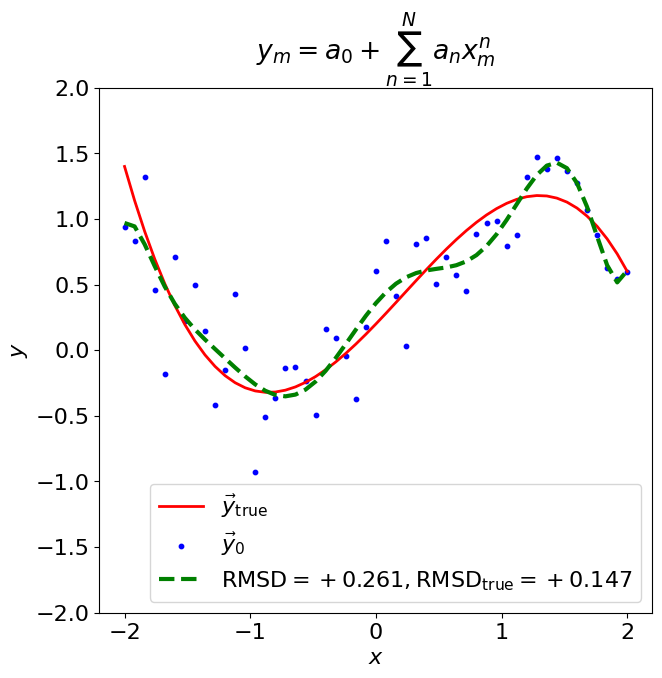

     :  TRUE  :  OLS
a_0  : +0.200 : +0.359
w_01 : +1.000 : +1.127
w_02 : +0.200 : -1.098
w_03 : -0.300 : -1.225
w_04 : +0.000 : +1.783
w_05 : +0.000 : +1.003
w_06 : +0.000 : -0.840
w_07 : +0.000 : -0.365
w_08 : +0.000 : +0.158
w_09 : +0.000 : +0.043
w_10 : +0.000 : -0.010


In [14]:
############################################
y_target = y_0
#
y_sets     = [ y_true_set, y_0_set ]
#
pdfFName = FilePath + FileBaseName + '-y0reg.pdf'
############################################
# 線形回帰オブジェクトを生成
reg = lm.LinearRegression()
#
# 回帰実行
reg.fit( X_ss, y_target )
#
############################################
# 再現データ
w_  = reg.coef_
a0_ = reg.intercept_
yreg_ = X_ss @ w_ + a0_
#
############################################
# 再現データのRMSD
residual_     = y_target - yreg_
residual_true = y_true   - yreg_
legend_ = r'${\rm RMSD}=%+.3f, {\rm RMSD}_{\rm true}=%+.3f$' % (np.std(residual_),np.std(residual_true))
#
yreg_set = [ yreg_, 0, legend_, 'green', 3, 'dashed' ]
#
y_sets.append( yreg_set )
#
fig = Grf_data( x, y_sets )
#
fig.savefig( pdfFName )
############################################
# omega, a0
w_OLS = sdash_vec * w_
#
a0_OLS = a0_ - mu_vec @ w_OLS
#
print( '     :  TRUE  :  OLS' )
print( 'a_0  : %+.3f : %+.3f' % ( a_0, a0_OLS ) )
#
for n in range( w_K ):
  print( 'w_%02d : %+.3f : %+.3f' % ( n+1, w_true[n], w_OLS[n] ) )

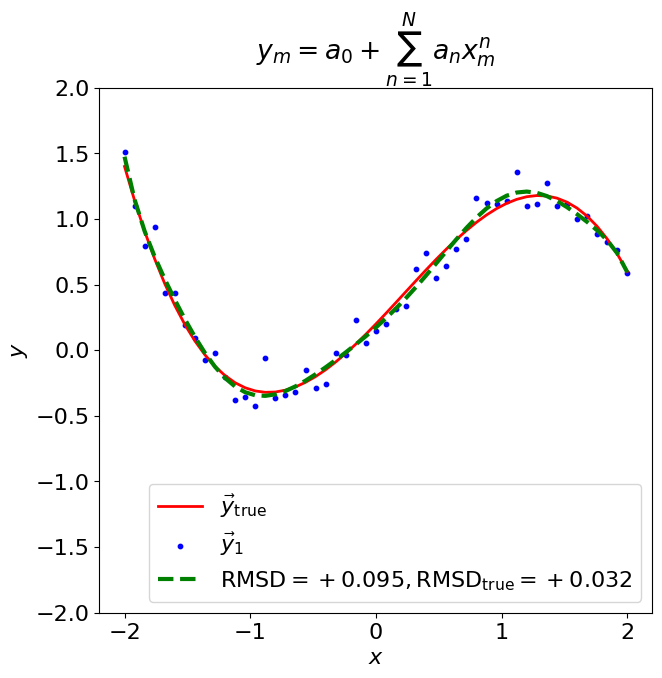

     :  TRUE  :  OLS
a_0  : +0.200 : +0.173
w_01 : +1.000 : +0.852
w_02 : +0.200 : +0.312
w_03 : -0.300 : +0.219
w_04 : +0.000 : -0.119
w_05 : +0.000 : -0.454
w_06 : +0.000 : +0.061
w_07 : +0.000 : +0.145
w_08 : +0.000 : -0.016
w_09 : +0.000 : -0.015
w_10 : +0.000 : +0.002


In [15]:
############################################
y_target = y_1
#
y_sets     = [ y_true_set, y_1_set ]
#
pdfFName = FilePath + FileBaseName + '-y1reg.pdf'
############################################
# 線形回帰オブジェクトを生成
reg = lm.LinearRegression()
#
# 回帰実行
reg.fit( X_ss, y_target )
#
############################################
# 再現データ
w_  = reg.coef_
a0_ = reg.intercept_
yreg_ = X_ss @ w_ + a0_
#
############################################
# 再現データのRMSD
residual_     = y_target - yreg_
residual_true = y_true   - yreg_
legend_ = r'${\rm RMSD}=%+.3f, {\rm RMSD}_{\rm true}=%+.3f$' % (np.std(residual_),np.std(residual_true))
#
yreg_set = [ yreg_, 0, legend_, 'green', 3, 'dashed' ]
#
y_sets.append( yreg_set )
#
fig = Grf_data( x, y_sets )
#
fig.savefig( pdfFName )
############################################
# omega, a0
w_OLS = sdash_vec * w_
#
a0_OLS = a0_ - mu_vec @ w_OLS
#
print( '     :  TRUE  :  OLS' )
print( 'a_0  : %+.3f : %+.3f' % ( a_0, a0_OLS ) )
#
for n in range( w_K ):
  print( 'w_%02d : %+.3f : %+.3f' % ( n+1, w_true[n], w_OLS[n] ) )

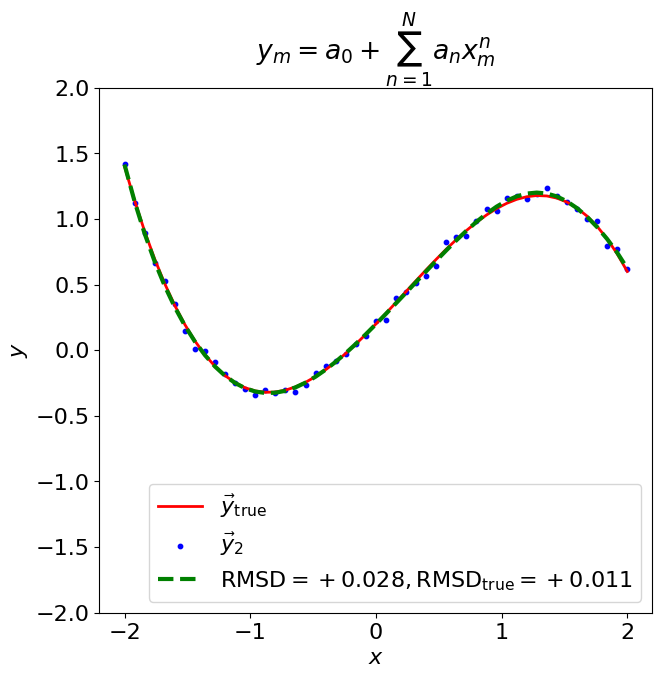

     :  TRUE  :  OLS
a_0  : +0.200 : +0.199
w_01 : +1.000 : +0.973
w_02 : +0.200 : +0.162
w_03 : -0.300 : -0.216
w_04 : +0.000 : +0.095
w_05 : +0.000 : -0.063
w_06 : +0.000 : -0.063
w_07 : +0.000 : +0.018
w_08 : +0.000 : +0.016
w_09 : +0.000 : -0.002
w_10 : +0.000 : -0.001


In [16]:
############################################
y_target = y_2
#
y_sets     = [ y_true_set, y_2_set ]
#
pdfFName = FilePath + FileBaseName + '-y2reg.pdf'
############################################
# 線形回帰オブジェクトを生成
reg = lm.LinearRegression()
#
# 回帰実行
reg.fit( X_ss, y_target )
#
############################################
# 再現データ
w_  = reg.coef_
a0_ = reg.intercept_
yreg_ = X_ss @ w_ + a0_
#
############################################
# 再現データのRMSD
residual_     = y_target - yreg_
residual_true = y_true   - yreg_
legend_ = r'${\rm RMSD}=%+.3f, {\rm RMSD}_{\rm true}=%+.3f$' % (np.std(residual_),np.std(residual_true))
#
yreg_set = [ yreg_, 0, legend_, 'green', 3, 'dashed' ]
#
y_sets.append( yreg_set )
#
fig = Grf_data( x, y_sets )
#
fig.savefig( pdfFName )
############################################
# omega, a0
w_OLS = sdash_vec * w_
#
a0_OLS = a0_ - mu_vec @ w_OLS
#
print( '     :  TRUE  :  OLS' )
print( 'a_0  : %+.3f : %+.3f' % ( a_0, a0_OLS ) )
#
for n in range( w_K ):
  print( 'w_%02d : %+.3f : %+.3f' % ( n+1, w_true[n], w_OLS[n] ) )